In [72]:
import sys
!{sys.executable} -m pip install matplotlib
import matplotlib.pyplot as plt

In [73]:
def toTime(tStr: str) -> float:
    tStr = tStr.strip()
    if 'ms' in tStr:
        return float(tStr[:-2]) / 1000

    return float(tStr[:-1])

def get_results(fn: str) -> tuple[list[int], list[int], list[int]]:

  with open(fn, 'r') as reader:
    hecs_line = reader.readline()
    sequential_time_line = reader.readline()
    parallel_times_line = reader.readline()

    seq_times = [ toTime(t) for t in sequential_time_line.split(' ')]
    times = parallel_times_line.split(" ")
    repeats = len(seq_times)

    x = [ int(n) for n in hecs_line.split(' ') ]
    y = [
      [ toTime(times[j * len(x) + i]) for j in range(repeats) ]
      for i in range(len(x))
    ]
  
  return x, seq_times, y

In [74]:
def get_wallclocks(y: list[int]) -> tuple[list[int], list[int]]:
  repeats = len(y[0])
  
  y_avg = [ sum(ys) / repeats for ys in y ]
  y_err = list(zip(*[
    [ max(ys) - y_avg, y_avg - min(ys) ]
    for y_avg, ys in zip(y_avg, y)
  ]))

  return y_avg, y_err

def get_speedups(y: list[int]) -> tuple[list[int], list[int]]:
  repeats = len(y[0])

  speed_ups = [
    [ y[0][j] / y[i][j] for j in range(repeats) ]
    for i in range(len(x))
  ]

  speed_up_avg = [ sum(xs) / repeats for xs in speed_ups ]
  speed_up_err = list(zip(*[
    [ max(xs) - x_avg, x_avg - min(xs) ]
    for x_avg, xs in zip(speed_up_avg, speed_ups)
  ]))

  return speed_up_avg, speed_up_err

def show_par_overhead(seqsN1: list[int], parsN1: list[int]):
  seqs_avg = sum(seqsN1) / len(seqsN1)
  pars_avg = sum(parsN1) / len(parsN1)
  overhead = (pars_avg / seqs_avg - 1) * 100

  print(
    f"\nWhen both using one core the sequential solution takes {seqs_avg:.2f} seconds "
    f"and the parallel solution takes {pars_avg:.2f} seconds")
  print(f"\nThus there is a parallelization overhead of {overhead:.2f}%")

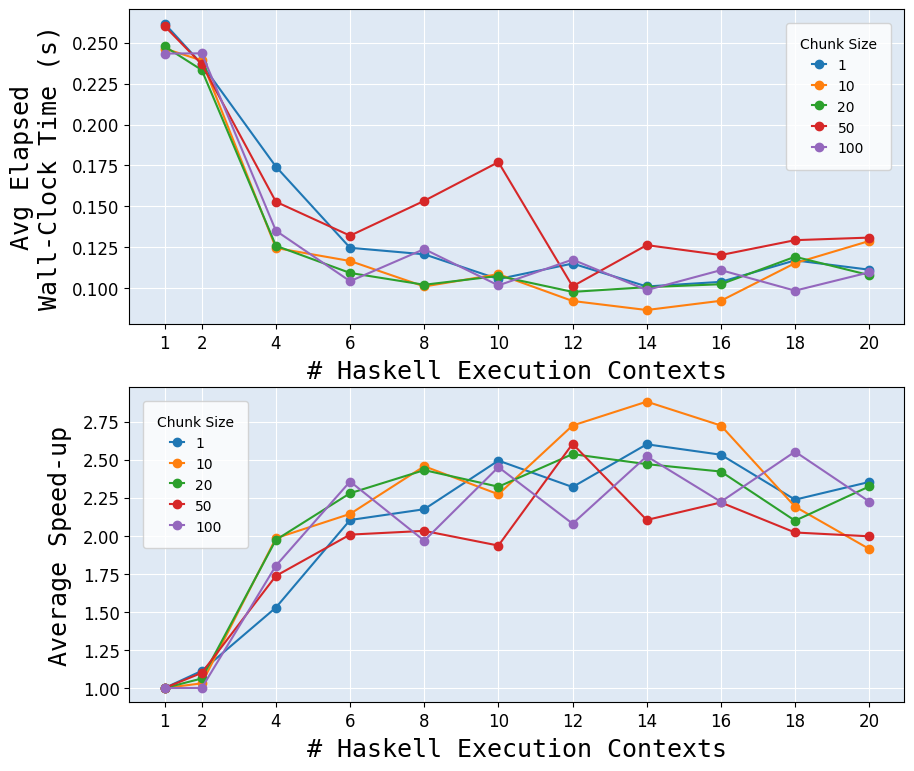

In [83]:
# figure set up
fontopts = {"fontfamily": 'monospace', "fontsize": 18}
fig, [ax1, ax2] = plt.subplots(2, 1, figsize=(10, 9))
for ax in [ax1, ax2]:
  ax.tick_params(labelsize='large')
  ax.set_xticks(x)
  ax.set_xlabel("# Haskell Execution Contexts", fontopts, labelpad=5)
  ax.set_facecolor('#dfe9f4')
  ax.grid(color='white', linestyle='-')

ax1.set_ylabel("Avg Elapsed\nWall-Clock Time (s)", fontopts, labelpad=7.5)
ax2.set_ylabel("Average Speed-up", fontopts, labelpad=7.5)

# --------
# plotting
# --------
src = "/Users/yunlan/Desktop/2022_fall/pfp/final_project/benchmark_results"
chunk_sizes = [1, 10, 20, 50, 100]

for chunk_size in chunk_sizes:
  fn = f"{src}/final_chunk{chunk_size}.txt"
  x, seqN1_times, y = get_results(fn)
  ys = [seqN1_times] + y[1:]

  # derived avg, err
  y_avg, y_err = get_wallclocks(ys)
  speedup_avg, speedup_err = get_speedups(ys)

  # plot curves
  ax1.plot(x, y_avg, 'o-', label=str(chunk_size))
  ax2.plot(x, speedup_avg, 'o-', label=str(chunk_size))

for ax in [ax1, ax2]:
  ax.legend(title='Chunk Size', title_fontsize='medium', handleheight=1, handlelength=1, borderpad=1, borderaxespad=1)
plt.savefig('par_perf_chunk_size', dpi=300)